In [1]:
from functools import total_ordering
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from collections import defaultdict
import subprocess
import string
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# {'ϔ': 0, 's': 1, 'j': 2, '\x0c': 3, 'ß': 4, 'k': 5, 'ϋ': 6, '}': 7, '7': 8, ')': 9, 'l': 10, '>': 11, 
#  'ꮪ': 12, 'w': 13, 'v': 14, ']': 15, '1': 16, 'ⅳ': 17, '\x08': 18, '♦': 19, 'y': 20, '!': 21, '/': 22, 
#  '|': 23, '$': 24, ',': 25, 'ς': 26, '_': 27, 'z': 28, 'ꭲ': 29, '*': 30, 't': 31, '4': 32, '¹': 33, 
#  '[': 34, 'σ': 35, '∞': 36, 'b': 37, 'a': 38, '+': 39, '(': 40, '9': 41, '\u1680': 42, 'h': 43, '?': 44, 
#  'ı': 45, 'm': 46, '0': 47, '"': 48, 'ꮢ': 49, ':': 50, '໐': 51, 'u': 52, '6': 53, '%': 54, 'å': 55, 
#  'é': 56, '3': 57, '£': 58, 'p': 59, '#': 60, '.': 61, 'ü': 62, '8': 63, '@': 64, 'g': 65, 'i': 66, 
#  'x': 67, 'ዐ': 68, '０': 69, '5': 70, 'd': 71, '\\': 72, '2': 73, 'ſ': 74, 'ꮅ': 75, 'π': 76, 'e': 77, 
#  '-': 78, '<': 79, ';': 80, '=': 81, '&': 82, 'ﬁ': 83, '~': 84, '\ufeff': 85, 'r': 86, '\t': 87, 
#  '\x00': 88, 'ꮛ': 89, '€': 90, 'n': 91, '{': 92, '\n': 93, '`': 94, 'а': 95, ' ': 96, 'o': 97, 'c': 98, 
#  '^': 99, 'q': 100, "'": 101, 'f': 102}

specials = ['\n', '}', ')', '>', ']', '!', '/', '|', '$', ',', '_', '*', '?', '"', ':', '%', '@', '.', '#', '\\', '\t', '~', '&', '=', ';', '<', '-', '{', ' ', '^', "'"]

In [3]:
onlyfiles = [join('annotated_rfcs/', f) for f in listdir('annotated_rfcs/') if isfile(join('annotated_rfcs/', f))]

window = 5

label_dict = { 'onr_rfcclass_nlt' : 0, 'onr_rfcclass_strdef' : 1, 'onr_rfcclass_msgStructure' : 2,
'onr_rfcclass_dataflow' : 3,
'onr_rfcclass_topologyDiag' : 4,
'onr_rfcclass_table' : 5,
'onr_rfcclass_stateTD' : 6,
'onr_rfcclass_cs' : 7,
'onr_rfcclass_protocolLayerDiag' : 8,
'onr_rfcclass_caption' : 9,
'onr_rfcclass_headers' : 10,
'onr_rfcclass_toc' : 11,
'onr_rfcclass_lex_spec' : 12 }

# for k in label_dict.keys():
#     label_dict[k]-=1
# print(label_dict)

In [4]:
def process_window(w):
    # print('w:',len(w)) 
    lst = []
    for k in w:
        lst.append([x for x in k])
    return lst

In [5]:
def make(onlyfiles, train=True):
    samples = []
    labels = []
    for r in onlyfiles:
        if train and r == 'annotated_rfcs/mqtt.txt':
            continue
        print('processing :', r)
        with open(r,  encoding="utf8", errors='ignore') as rfh:
            lines = rfh.readlines()
            cur_tag = 'onr_rfcclass_nlt'
            cur_label = label_dict[cur_tag]
            for i,l in enumerate(lines):
                if l=='\n':
#                     print('yowzaa!!')
                    continue
                if 'onr_rfcclass' in l:
                    if 'onr_rfcclass_references_start' in l:
                        break
                    if l.startswith('<end_'):
                        cur_tag = 'onr_rfcclass_nlt'
                        cur_label = label_dict[cur_tag]
                        continue
                    else:
                        cur_tag = l.strip()[1:-1]
                        # print(cur_tag)
                        cur_label = label_dict[cur_tag]
                        continue
                if i<=window: # lines before the window'th line
                    lst = process_window(lines[i:i+window+1])
                    smpl = [['a' for _ in range(50)] for _ in range(window)] + lst
                    # print(len(smpl))
                    assert len(smpl)==2*window+1
                elif i==len(lines)-1:
                    lst = process_window(lines[i-window:i+1])
                    smpl = lst + [['a' for _ in range(50)] for _ in range(window)]
                    # print(len(smpl))
                    assert len(smpl)==2*window+1
                else:
                    smpl = process_window(lines[i-window:i+1]) + process_window(lines[i+1:i+window+1])
                    # print(len(smpl))
                    assert len(smpl)==2*window+1
                samples.append(smpl)
                labels.append(cur_label)
    for _ in range(window):
        samples.pop()
        labels.pop()
    return samples, labels

In [6]:
samples, labels = make(onlyfiles)

processing : annotated_rfcs/rfc2131.txt
processing : annotated_rfcs/rfc1035.txt
processing : annotated_rfcs/rfc1661.txt
processing : annotated_rfcs/rfc2616.txt
processing : annotated_rfcs/rfc1001.txt


In [7]:
samples_mqtt, labels_mqtt = make(['annotated_rfcs/mqtt.txt'], train = False)

processing : annotated_rfcs/mqtt.txt


In [8]:
print(len(samples_mqtt))
print(len(samples))

1279
14194


In [9]:
# for i in samples[len(samples)//2]:
#     print(''.join(i))

### RFC character bookkeepping

In [10]:
# get max line in RFCs
onlyfiles = [join('../rfcs', f) for f in listdir('../rfcs') if isfile(join('../rfcs', f))]
length_max = []
for r in onlyfiles:
    with open(r,  encoding="utf8", errors='ignore') as rfh:
        lines = rfh.readlines()
        for l in lines:
            length_max.append([l, len(l)])
#ascending
length_max = sorted(length_max, key=lambda x:x[1], reverse=True)
# extract starting from the third element

def get_char_vocab():
    max_set = set()
    onlyfiles = [join('../rfcs', f) for f in listdir('../rfcs') if isfile(join('../rfcs', f))]
    for r in onlyfiles:
        with open(r,  encoding="utf8", errors='ignore') as rfh:
            lines = rfh.readlines()
            for l in lines:
                l = l.lower()
                l = set(l)
                max_set = max_set.union(l)
    return max_set

print('max length of rfc line:', length_max[2][1])

# vocab is the set of all chars in RFCs (mentioned above)
# need to filter down to lowercase alphabets and chosen special characters
vocab = get_char_vocab()

# allowed = list(string.ascii_lowercase) + [str(x) for x in range(10)] + specials
allowed = ['char'] + ['digit'] + specials
# allowed = ['char'] + ['digit'] + ['specials']

num_feat = len(allowed)+1

char_to_idx = {}
idx_to_char = {}
for i,e in enumerate(allowed):
    # allowed chars get an integer
    # all others get unknown (idx = len(allowed))
    char_to_idx[e] = i
    idx_to_char[i] = e
    

max length of rfc line: 82


In [11]:
idx_to_char[len(allowed)] = 'å'
print(idx_to_char)

{0: 'char', 1: 'digit', 2: '\n', 3: '}', 4: ')', 5: '>', 6: ']', 7: '!', 8: '/', 9: '|', 10: '$', 11: ',', 12: '_', 13: '*', 14: '?', 15: '"', 16: ':', 17: '%', 18: '@', 19: '.', 20: '#', 21: '\\', 22: '\t', 23: '~', 24: '&', 25: '=', 26: ';', 27: '<', 28: '-', 29: '{', 30: ' ', 31: '^', 32: "'", 33: 'å'}


In [12]:
cnt=0
c=0
for s in samples:
    for l in s:
        c+=1
        if l==['\n']:
            cnt+=1
print('ratio of blank lines to total lines:', cnt/c)

ratio of blank lines to total lines: 0.226581013744604


In [13]:
for i,e in enumerate(samples):
    for j,v in enumerate(e):
        if v==['\n']:
            samples[i][j]=['\n']*length_max[2][1]

for i,e in enumerate(samples_mqtt):
    for j,v in enumerate(e):
        if v==['\n']:
            samples_mqtt[i][j]=['\n']*length_max[2][1]

### Build samples : with context this time

In [14]:
_maxlen = length_max[2][1]
def create_samples(samples):
    '''
    read each sample, convert line to list of integers (indexes) using char_to_idx
    join the resulting vector to master array
    return array
    '''
    data = []
    for s in samples:
        mini_data = []
        for line_list in s:
            ll = []
            cur_len = len(line_list)
            for char in line_list:
                if char.isalpha():
                    ll.append(char_to_idx['char'])
#                     ll.append(char_to_idx[char])
                elif char.isdigit():
                    ll.append(char_to_idx['digit'])
#                     ll.append(char_to_idx[digit])
                elif char in specials:
                    ll.append(char_to_idx[char])
#                     ll.append(char_to_idx['specials'])
                else:
                    ll.append(len(allowed))
            # pad sequences shorter than _maxlen
            pad = _maxlen - cur_len
            for _ in range(pad):
                ll.append(len(allowed))
            mini_data.append(ll)
        data.append(mini_data)
    return np.array(data)

In [15]:
X = create_samples(samples)
y = np.array(labels)

X_mqtt = create_samples(samples_mqtt)
y_mqtt = np.array(labels_mqtt)

In [16]:
print(X.shape)
print(y.shape)
print(X_mqtt.shape)
print(y_mqtt.shape)

(14194, 11, 82)
(14194,)
(1279, 11, 82)
(1279,)


In [17]:
def int_to_one_hot(idx):
    res = np.zeros((1,num_feat))
    res[0][idx] = 1
    return res

In [18]:
vector_len = len(allowed)+1
big_mat = []
for sample in X: # (5,82)
    mat = []
    for s in sample: # (82,)
        idx_mat = []
        for idx in s:
            cand = np.zeros((vector_len))
            cand[idx] = 1 #(1x33)
            idx_mat.append(cand)
        mat.append(idx_mat)
    big_mat.append(np.array(mat))
    
big_mat = np.array(big_mat)
print(big_mat.shape)

(14194, 11, 82, 34)


In [19]:
big_mat_mqtt = []
for sample in X_mqtt: # (5,82)
    mat = []
    for s in sample: # (82,)
        idx_mat = []
        for idx in s:
            cand = np.zeros((vector_len))
            cand[idx] = 1 #(1x33)
            idx_mat.append(cand)
        mat.append(idx_mat)
    big_mat_mqtt.append(np.array(mat))
    
big_mat_mqtt = np.array(big_mat_mqtt)
print(big_mat_mqtt.shape)

(1279, 11, 82, 34)


### (m,n,p,q) : m: samples, n: window, p: line length, q: one hot characters in line

In [20]:
print('data and labels shape:', big_mat.shape, y.shape)
print('data and labels shape mqtt:', big_mat_mqtt.shape, y_mqtt.shape)

data and labels shape: (14194, 11, 82, 34) (14194,)
data and labels shape mqtt: (1279, 11, 82, 34) (1279,)


In [21]:
sh = big_mat.shape
sh_mqtt = big_mat_mqtt.shape
big_mat = big_mat.reshape(sh[0], -1)
big_mat_mqtt = big_mat_mqtt.reshape(sh_mqtt[0], -1)

In [22]:
# filter data matrix to ignore the nlt samples
# big_mat = big_mat[y!=-1]
# y = y[y!=-1]
# big_mat_mqtt = big_mat_mqtt[y_mqtt!=-1]
# y_mqtt = y_mqtt[y_mqtt!=-1]
print(big_mat.shape, y.shape)
print(big_mat_mqtt.shape, y_mqtt.shape)

(14194, 30668) (14194,)
(1279, 30668) (1279,)


In [23]:
c = len(label_dict)

In [24]:
# labels to one hot
# labels = np.zeros((y.shape[0], c))
# print(labels.shape)
# for i in range(labels.shape[0]):
#     labels[i][y[i]]=1

In [25]:
for i in range(13):
    print('label: {}, samples : {}'.format(i, y[y==i].shape[0]))
print('!!!!!!!!!')
for i in range(13):
    print('label_mqtt: {}, samples : {}'.format(i, y_mqtt[y_mqtt==i].shape[0]))

label: 0, samples : 11980
label: 1, samples : 7
label: 2, samples : 402
label: 3, samples : 447
label: 4, samples : 65
label: 5, samples : 259
label: 6, samples : 57
label: 7, samples : 0
label: 8, samples : 0
label: 9, samples : 13
label: 10, samples : 0
label: 11, samples : 560
label: 12, samples : 404
!!!!!!!!!
label_mqtt: 0, samples : 1079
label_mqtt: 1, samples : 0
label_mqtt: 2, samples : 88
label_mqtt: 3, samples : 46
label_mqtt: 4, samples : 0
label_mqtt: 5, samples : 0
label_mqtt: 6, samples : 0
label_mqtt: 7, samples : 0
label_mqtt: 8, samples : 0
label_mqtt: 9, samples : 0
label_mqtt: 10, samples : 0
label_mqtt: 11, samples : 47
label_mqtt: 12, samples : 19


## PyTorch data and Model training for line classification

In [26]:
import torch
import torch.nn as nn
# from models import lstm_model, classifier
from torch.nn import LSTM, Linear, ReLU, BatchNorm1d, Dropout, MaxPool1d
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [27]:
input_size = big_mat.shape[1]
batch_size = 1024
hidden_size = 128
num_layers = 2
device = 'cuda'
epochs = 100
counter = 0
print_every = 100
clip = 5
valid_loss_min = np.Inf

### big mat size: samples x features

In [28]:
X_train, X_test, y_train, y_test = train_test_split(big_mat, y, test_size=0.1, random_state=42)
print('train samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)) 
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=batch_size, 
                                                    shuffle=True)
            
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                    batch_size=batch_size, 
                                                    shuffle=False)

train samples: 12774, test samples: 1420


In [29]:
class classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(classifier, self).__init__()
        self.fc1 = Linear(input_size, 512)
        self.bn1 = BatchNorm1d(512)
        self.r1 = ReLU()
        self.d1 = Dropout(p=0.5)
        self.m1 = MaxPool1d(3,stride = 1)
        
        self.fc2 = Linear(512, 128)
        self.bn2 = BatchNorm1d(128)
        self.r2 = ReLU()
        self.d2 = Dropout(p=0.5)
        self.m2 = MaxPool1d(3,stride = 1)
        
        self.fc3 = Linear(128, 32)
#         self.d3 = Dropout(p=0.5)
        self.r3 = ReLU()
        self.fc4 = Linear(32,num_classes)

    def forward(self, x):
        x = self.d1 ( self.r1( self.bn1 ( self.fc1(x) ) ) )
#         x = self.m1(x)
        x = self.d2 ( self.r2( self.bn2 ( self.fc2(x) ) ) )
#         x = self.m2(x)
        
        x = self.r3(self.fc3(x))
        out = self.fc4(x)
        return out

In [30]:
clf = classifier(input_size, c).to(device)
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)

In [31]:
def plot_current_loss_profile(train_loss_list, val_loss_list):
    plt.plot(range(len(train_loss_list)), train_loss_list, label='train')
    plt.plot(range(len(val_loss_list)), val_loss_list, label='val')
    plt.legend(loc='upper right')
    plt.show()

[EPOCHS:0] epoch_loss:2.063412207823533, val loss:1.1440152525901794, correct: 1277
[EPOCHS:1] epoch_loss:1.0749380130034227, val loss:0.5437600314617157, correct: 1295
[EPOCHS:2] epoch_loss:0.5037906376215128, val loss:0.382465198636055, correct: 1311
[EPOCHS:3] epoch_loss:0.32042882763422453, val loss:0.276432141661644, correct: 1317
[EPOCHS:4] epoch_loss:0.251029181938905, val loss:0.2202514410018921, correct: 1330
[EPOCHS:5] epoch_loss:0.20299917115614965, val loss:0.17418739199638367, correct: 1350
[EPOCHS:6] epoch_loss:0.1632799506187439, val loss:0.13618825748562813, correct: 1385
[EPOCHS:7] epoch_loss:0.127483443571971, val loss:0.1034071110188961, correct: 1390
[EPOCHS:8] epoch_loss:0.09849187903679334, val loss:0.07355990633368492, correct: 1398
[EPOCHS:9] epoch_loss:0.07445830851793289, val loss:0.05631082318723202, correct: 1400
[EPOCHS:10] epoch_loss:0.06124091979402762, val loss:0.04661058820784092, correct: 1401
[EPOCHS:11] epoch_loss:0.049036783954271905, val loss:0.037

[EPOCHS:92] epoch_loss:0.002542281158429642, val loss:0.01830102689564228, correct: 1414
[EPOCHS:93] epoch_loss:0.002521093003451824, val loss:0.01871885033324361, correct: 1413
[EPOCHS:94] epoch_loss:0.0024703514869683064, val loss:0.020333504769951105, correct: 1413
[EPOCHS:95] epoch_loss:0.001995839662133501, val loss:0.016617147251963615, correct: 1413
[EPOCHS:96] epoch_loss:0.0020511299998571095, val loss:0.01732051931321621, correct: 1415
[EPOCHS:97] epoch_loss:0.0024336346675856756, val loss:0.01968430122360587, correct: 1414
[EPOCHS:98] epoch_loss:0.0021678145276382565, val loss:0.0193395153619349, correct: 1413
[EPOCHS:99] epoch_loss:0.002727974528590074, val loss:0.021816673688590527, correct: 1413


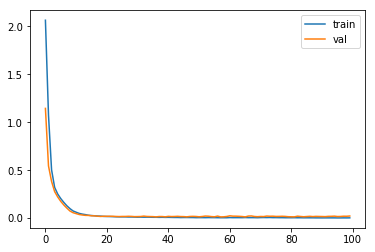

In [32]:
clf.train()
train_loss_total = []
val_loss_total = []
for e in range(epochs):
    running_epoch_loss = 0
    correct = 0
    for data, target in train_loader:
        counter+=1
        data, target = data.to(device).float(), target.to(device).long()
        clf.zero_grad()
        output = clf(data)
        loss = criterion(output, target)
        running_epoch_loss+=loss.item()
        loss.backward()
        # nn.utils.clip_grad_norm_(clf.parameters(), clip) # need this??
        optimizer.step()
#     print('correct first: ', correct.item())
    clf.eval()
    running_val_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device).long()
        output = clf(data)
        
        correct+=torch.sum(torch.argmax(output, dim=1)==target)
        
        val_loss = criterion(output, target)
        running_val_loss+=val_loss.item()
    train_loss_total.append(running_epoch_loss/len(train_loader))
    val_loss_total.append(running_val_loss/len(test_loader))
    clf.train()
    print('[EPOCHS:{}] epoch_loss:{}, val loss:{}, correct: {}'.format(e, train_loss_total[-1], val_loss_total[-1], correct))
plot_current_loss_profile(train_loss_total, val_loss_total)
torch.save(clf.state_dict(), 'classifier_nway.pth')

### Other ideas

1. Autoencoders to latents?
<br>
2. Embedding matrix?
<br>
3. reduce sparsity
<br>
4. Txt2pic: converts each char in each line of RFC into a pixel value. 
<br>

### AI:
post processing : break RFCs into separate blocks and label the dominant. Plot the CM for blocks.

## MQTT exp

In [33]:
A, X_test, ya, y_test = train_test_split(big_mat_mqtt, y_mqtt, test_size=0, random_state=42)
print('test samples: {}'.format(A.shape[0]))

mqtttest = TensorDataset(torch.Tensor(A), torch.Tensor(ya)) 
# test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

mqtttest_loader = torch.utils.data.DataLoader(dataset=mqtttest,
                                                    batch_size=1024, 
                                                    shuffle=True)

clf = classifier(input_size, c).to(device)
clf.load_state_dict(torch.load('classifier_nway.pth'))

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

r = 6 # strdef
miscls = []
correct_classified = []

y_true, y_pred = [], []
for data, target in mqtttest_loader:
    data, target = data.to(device), target.to(device).long()
    output = clf(data)
    
    _y_pred = torch.argmax(output, dim=1).cpu().detach().numpy().tolist()
    y_pred.extend(_y_pred)
    
    _target = target.cpu().detach().numpy().tolist()
    y_true.extend(_target)
    
    for i in range(len(_y_pred)):
        if _target[i]==r and _y_pred[i]!=r:
            miscls.append(data.cpu().detach().numpy()[i])
        elif _target[i]==r and _y_pred[i]==r:
            correct_classified.append(data.cpu().detach().numpy()[i])
    
cm = confusion_matrix(y_true, y_pred)

print(cm)

# df_cm = pd.DataFrame(cm, range(9), range(9))
# sns.set(df_cm, annnot=True, annot_kws={"size": 10}, fmt='g') # font size

test samples: 1279
[[1077    0    0    1    0    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    1   21   32   31    0    0    1    0    2]
 [   4    0    0   37    1    0    1    0    0    3]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0   47    0]
 [  15    0    0    0    0    0    0    0    0    4]]


In [34]:
label_mqtt: 0, samples : 1528
label_mqtt: 1, samples : 3
label_mqtt: 2, samples : 97
label_mqtt: 3, samples : 48
label_mqtt: 4, samples : 0
label_mqtt: 5, samples : 0
label_mqtt: 6, samples : 0
label_mqtt: 7, samples : 0
label_mqtt: 8, samples : 0
label_mqtt: 9, samples : 0
label_mqtt: 10, samples : 0
label_mqtt: 11, samples : 47
label_mqtt: 12, samples : 19

SyntaxError: invalid syntax (<ipython-input-34-18d587a9dc61>, line 1)

In [ ]:
print('total target class misclassified',len(miscls))

def one_hot_to_idx(t):
    r = []
    for i in t:
        b = np.where(i==1)[0][0]
        r.append(b)
    return np.array(r)

def idx_to_charr(v):
    r = []
    for i in v:
        r.append(idx_to_char[i])
    return r

middleelement = 11//2
for i,e in enumerate(miscls):
    r = one_hot_to_idx(e.reshape(5, 82, 34)[middleelement])
    print(i)
    print(''.join(idx_to_charr(r)))
    print('\n---------next line-----------\n')

In [ ]:
# miscls[4][middleelement]

In [ ]:
# 2131:
# 'onr_rfcclass_nlt' : 0, 
# 'onr_rfcclass_strdef' : 1, 
# 'onr_rfcclass_msgStructure' : 2,
# 'onr_rfcclass_dataflow' : 3,
# 'onr_rfcclass_topologyDiag' : 4,
# 'onr_rfcclass_table' : 5,
# 'onr_rfcclass_stateTD' : 6,
# 'onr_rfcclass_cs' : 7,
# 'onr_rfcclass_protocolLayerDiag' : 8,
# 'onr_rfcclass_caption' : 9,
# 'onr_rfcclass_headers' : 10,
# 'onr_rfcclass_toc' : 11,
# 'onr_rfcclass_lex_spec' : 12

# test samples: 2276
#  [1888    0    0    0    0    0    0    0    0    0]
#  [   0    0    0    0    0    0    0    0    0    0]
#  [   0    0   33    1    0    2    0    0    0    0] msgstructure
#  [   1    0   16   55    0    0    0    0    0    0] dataflow
#  [   0    0    0    0    0    0    0    0    0    0]
#  [ 106    2   11   43    0   16    0    0    0    2] table
#  [   2    0    2    2    7    1    0    0   29    0] statediag
#  [   2    3    0    2    0    0    0    0    0    6] captions -- also not standardized
#  [   0    0    0    0    0    0    0    0   44    0] table of contents
#  [   0    0    0    0    0    0    0    0    0    0]


# [[ 0  0  0  0  0  0  0  0  0]
#  [ 0 35  1  0  0  0  0  0  0]
#  [ 0  6 47 13  0  0  0  0  6]
#  [ 0  0  0  0  0  0  0  0  0]
#  [11 20 59  8 39  2  0  5 36]
#  [ 0 11  1  2  0  0  0 29  0]
#  [ 0  2  0  0  0  0  0  1 10]
#  [ 0  0  0  0  0  0  0 44  0]
#  [ 0  0  0  0  0  0  0  0  0]]


# label_mqtt: 0, samples : 1888
# label_mqtt: 1, samples : 0
# label_mqtt: 2, samples : 36
# label_mqtt: 3, samples : 72
# label_mqtt: 4, samples : 0
# label_mqtt: 5, samples : 180
# label_mqtt: 6, samples : 43
# label_mqtt: 7, samples : 0
# label_mqtt: 8, samples : 0
# label_mqtt: 9, samples : 13
# label_mqtt: 10, samples : 0
# label_mqtt: 11, samples : 44
# label_mqtt: 12, samples : 0


##############################################################################################################

# 1661: window 2
# [[2511    0    2    8    0    6    0    9    6]
#  [   3    0    2    7    5    0    0    0    1] strdef
#  [  34    0   63   16    0    6    0    0    0]
#  [   0    0    0    0    0    0    0    0    0]
#  [   0    0    0    0    0    0    0    0    0]
#  [  29    0    3   39    0    5    1    0    4] table
#  [   0    0    7    6    0    0    1    0    0] stateTD
#  [   7    0    0    0    0    0    0   39    0]
#  [   0    0    0    0    0    0    0    0    0]]


# label_mqtt: 0, samples : 2537
# label_mqtt: 1, samples : 18
# label_mqtt: 2, samples : 119
# label_mqtt: 3, samples : 0
# label_mqtt: 4, samples : 0
# label_mqtt: 5, samples : 81
# label_mqtt: 6, samples : 14
# label_mqtt: 7, samples : 0
# label_mqtt: 8, samples : 0
# label_mqtt: 9, samples : 0
# label_mqtt: 10, samples : 0
# label_mqtt: 11, samples : 46
# label_mqtt: 12, samples : 0

# strdef : very few examples (1661, mqtt) and both are wildly different
# toc now fixed
# table : postprocessing fixes
# stateTD : very few examples and very varied


# [[ 0  0  5  4  0  0  0  9] strdef
#  [ 0 79 30  1  1  0  0  8] msgstructure
#  [ 0  0  0  0  0  0  0  0]
#  [ 0  0  0  0  0  0  0  0]
#  [ 1  1 39  0 25  1  0 14] 
#  [ 0  3 10  0  1  0  0  0]
#  [ 0  0  0  0  0  0 46  0]
#  [ 0  0  0  0  0  0  0  0]]



##############################################################################################################



# test samples: 2675
# [[2241    2    0   21    0   10    0    0    3]
#  [   0    0    0    0    0    0    0    0    0]
#  [  11    0   55  137   23    2    2    0    1]
#  [   0    0    1   69    8    0    0    0    2]
#  [   0    0    2   11    1    0    0    0    1]
#  [   0    0    0    0    0    0    0    0    0]
#  [   0    0    0    0    0    0    0    0    0]
#  [   0    0    0    0    0    0    0   72    0]
#  [   0    0    0    0    0    0    0    0    0]]

# label_mqtt: 0, samples : 2277
# label_mqtt: 0, samples : 0
# label_mqtt: 1, samples : 231
# label_mqtt: 2, samples : 80
# label_mqtt: 3, samples : 15
# label_mqtt: 4, samples : 0
# label_mqtt: 5, samples : 0
# label_mqtt: 6, samples : 0
# label_mqtt: 7, samples : 0
# label_mqtt: 8, samples : 0
# label_mqtt: 9, samples : 0
# label_mqtt: 10, samples : 72
# label_mqtt: 11, samples : 0
# label_mqtt: 12, samples : 0